# **F1_DNF_ANALASYS**

### **Intro**


- This project has the goal of idetifying whhether or not an F1 car will finish a race.
- The dataset used from kaggle is: https://www.kaggle.com/datasets/pranay13257/f1-dnf-classification


### **Table of contents**

**[Imports](#Imports)**

**[Part_1_Dataprossesing](#Part_1_Dataprossesing)**

**[Part_2_Models](#Part_2_Models)**
- [Logistical_regression](#Logistical_regression)
- [Random_Forest](#Random_Forest)
- [Support_Vector_Machine](#Support_Vector_Machine)
- [Neural_Network](#Neural_Network)

**[Part_3_Coclusion_and_performance](#Part_3_Coclusion_and_performance)**



## **Imports**

In [85]:
# ===============================
# Standard scientific stack
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# Scikit-learn tools
# ===============================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer #Importing make_scorer because using balanced f1 score doesn't work as expected

# ===============================
# TensorFlow / Keras
# ===============================
import tensorflow as tf
from tensorflow.keras import models, layers


## **Useful lab-methods**

In [86]:
def get_param_order(param_grid):
    param0 = [key for key, value in param_grid.items() if len(value) == 2]
    param1 = param_grid.keys() - param0
    return [param0[0],param1.pop()]

def unpack_gridsearch(gs):

    param_grid = gs.param_grid
    result = gs.cv_results_
    
    cols = ['mean_test_score']
        
    param_order = get_param_order(param_grid)

    f0 = 'param_{}'.format(param_order[0])
    f1 = 'param_{}'.format(param_order[1])
    f0vals = param_grid[param_order[0]]
    f1vals = param_grid[param_order[1]]
    
    X = dict.fromkeys(f0vals)

    for f0val in f0vals:
        X[f0val] = pd.DataFrame(index=f1vals,columns=cols,dtype=float)

    for f0val in f0vals:
        for f1val in f1vals:
            ind = (result[f0]==f0val) & (result[f1]==f1val)
            for col in cols:
                X[f0val].loc[f1val,col] = float(result[col][ind][0])

    return { 'scoregrid':X, 
             'best_params':gs.best_params_, 
             'best_estimator':gs.best_estimator_, 
             'best_score':gs.best_score_,
             'param_grid':param_grid
            } 

def plot_grid_result(result,log=True, baseline = None):

    param_grid = result['param_grid']
    X = result['scoregrid']
    param_order = get_param_order(param_grid)
    cols = ['mean_test_score']
    labels = [' (f1)']
    colors = ['r','b']
    linestyles = ['--', '-']

    f0vals = param_grid[param_order[0]]

    plt.figure(figsize=(10,4))
    for f0ind, f0val in enumerate(f0vals):
        for c, col in enumerate(cols):
            if log:
                plt.semilogx(X[f0val][col],color=colors[c],linestyle=linestyles[f0ind],marker='o',label='{} {}'.format(f0val,labels[c]))
            else:
                plt.plot(X[f0val][col],color=colors[c],linestyle=linestyles[f0ind],marker='o',label='{} {}'.format(f0val,labels[c]))
    if baseline is not None:
        plt.axhline(y=baseline, color='green', linestyle='-.', linewidth=2, label=f'Baseline ({baseline:.4f})')
    plt.legend(fontsize=12)
    plt.grid(':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()




from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

def hypersolve(model,param_grid, X_train, y_train):
    # 1. Create the pipeline model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # 2. Construct the `GridSearchCV` object as was done in part 5.2
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid, 
        scoring='accuracy', 
        cv=3, 
        refit='accuracy'
    )
    
    # 3. Run the grid search
    gs = gs.fit(X_train, y_train)
    
    # 4. Run `unpack_gridsearch` to obtain the results dictionary.
    result = unpack_gridsearch(gs)

    # 5. Plot the result with `plot_grid_result`
    plot_grid_result(result)

    # 6. return result
    return result

## **Part_1_Dataprossesing**

#### Loading data and prining out head & shape ###

In [87]:
#Importing data to dataframe
raw_data = pd.read_csv('data.csv')
print(raw_data.head().to_string())
print("Shape: ", raw_data.shape)

   resultId  raceId  year  round  grid  positionOrder  points  laps milliseconds fastestLap rank fastestLapTime fastestLapSpeed        driverRef     surname forename         dob nationality_x constructorRef                          name nationality_y     circuitRef  circuitId        name_y    location  country      lat        lng  alt        date  target_finish
0      2460     136  2002     13    11              4     3.0  77.0          NaN         \N   \N             \N              \N        raikkonen   Räikkönen     Kimi  1979-10-17       Finnish        mclaren                   Hungaroring       British    hungaroring         11       McLaren    Budapest  Hungary  47.5789   19.24860  264  2002-08-18              1
1     11565     483  1981      1    23             21     0.0  16.0           \N         \N   \N             \N              \N           watson      Watson     John  1946-05-04       British        mclaren                    Long Beach       British     long_beach       

#### Print overview of columns containing NA values, and dropping using 90% threshold ###

In [88]:
# Make sure other types of missing data is also registered as missing data
missing_markers = ['\\N', 'NULL', 'null', ''] 
raw_data = raw_data.replace(missing_markers, np.nan)

nullValues = raw_data.isnull().sum()
print("Rows with NA and NA count: ")
print(nullValues[nullValues > 0])
print("\nShape with 90% threshold for dropping column:")
thresh = round(0.9*raw_data.shape[0])
trimmed_raw_data = raw_data.dropna(axis=1, thresh=thresh)
print(trimmed_raw_data.shape)
print(trimmed_raw_data.columns)

Rows with NA and NA count: 
points              971
laps                978
milliseconds       7393
fastestLap         6895
rank               6798
fastestLapTime     6895
fastestLapSpeed    7191
dtype: int64

Shape with 90% threshold for dropping column:
(10000, 26)
Index(['resultId', 'raceId', 'year', 'round', 'grid', 'positionOrder',
       'points', 'laps', 'driverRef', 'surname', 'forename', 'dob',
       'nationality_x', 'constructorRef', 'name', 'nationality_y',
       'circuitRef', 'circuitId', 'name_y', 'location', 'country', 'lat',
       'lng', 'alt', 'date', 'target_finish'],
      dtype='object')


### Further feature selection ###
Some columns have leakage features, meaning they have a 1-1 correlation with what we try to predict.These need to be removed as they will make the predictions too "easy". Some of these are also measurements made after after the target value is measured, and therefore don't have any predictive power. E.g. "positionOrder" and "points", which are based upon whether the driver finishes the race or not. <br>
Will keep features 'year', 'round', 'grid', 'constructorRef', 'circuitRef', 'alt', 'date' as well as 'target_finish' <br>
Reasons one by one: <br><br>

##### Id's #####
- resultId: DROP – not useful

- raceId: DROP – not useful

- circuitId: DROP – Redundant with circuitRef

##### Race metadata #####

- year: KEEP – DNF rates may vary over the years

- round: KEEP – Early/late season influences DNF

- date: KEEP – Weather/season patterns

- country: DROP - redundant with circuitRef

##### Driver & team #####

- driverRef: DROP - High cardinality, too sparse. Data of retired drivers unuseful for future drivers

- surname: DROP – same reason as driverRef

- forename: DROP – same reason as driverRef

- dob: DROP – weak predictor

- nationality_x: DROP – Weak predictor

- constructorRef: KEEP – Team strongly impacts DNF

- nationality_y: DROP – irrelevant / redundant to constructorRef

##### Performance stats #####

- grid: KEEP – Starting position affects crash risk

- positionOrder: DROP – Leakage (reveals final result)

##### Circuit info #####

- circuitRef: KEEP – Tracks differ in DNF probability

- name: DROP – Duplicate of circuitRef

- name_y: DROP – Another duplicate

- location: DROP – Text field, not useful

##### Geographical #####

- lat: DROP – Raw coordinate not meaningful

- lng: DROP – Same as above

- alt: KEEP - altitude of tracks may be predicitive  


In [89]:
keep_cols = [
    'year', 'round', 'grid', 'constructorRef',
    'circuitRef', 'alt', 'date',
    'target_finish'
]
clean_data = trimmed_raw_data[keep_cols]
print("Shape:", clean_data.shape)
print("Features:",clean_data.columns)

Shape: (10000, 8)
Features: Index(['year', 'round', 'grid', 'constructorRef', 'circuitRef', 'alt', 'date',
       'target_finish'],
      dtype='object')


#### Dropping rows with NA values (redundant as columns containing NA are removed already) ###

In [90]:
clean_data = clean_data.dropna()
print("Shape after dropping rows with NA values and columns with >90% NA values:\n",clean_data.shape)

Shape after dropping rows with NA values and columns with >90% NA values:
 (10000, 8)


#### Printing out describtion of dataframe, and ranked correlation between numerical features for analysis ###

In [91]:
print(clean_data.describe().to_string())
print("\nCorrelation between numerical features and target_finish ranked on abs value")
print(clean_data.corr(numeric_only=True)['target_finish'].sort_values(key=abs, ascending=False)[1:])

               year         round          grid           alt  target_finish
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.000000
mean    1991.466600      8.540100     11.176200    281.465900       0.289500
std       20.060237      5.085487      7.241008    414.586363       0.453553
min     1950.000000      1.000000      0.000000     -7.000000       0.000000
25%     1977.000000      4.000000      5.000000     18.000000       0.000000
50%     1991.000000      8.000000     11.000000    153.000000       0.000000
75%     2009.000000     12.000000     17.000000    401.000000       1.000000
max     2024.000000     24.000000     34.000000   2227.000000       1.000000

Correlation between numerical features and target_finish ranked on abs value
grid    -0.344964
year     0.276936
round    0.123115
alt     -0.043222
Name: target_finish, dtype: float64


#### Handling 'object' values ###

Will use a reduced One Hot Encoding. Let the top 10 most common values per feature be one hot encoded, place all other values under a group called 'other...'

Then convert date to month, and OHE it

In [92]:
clean_data["date"] = pd.to_datetime(clean_data["date"]).dt.month
clean_data = clean_data.rename(columns={"date":"month"})

In [93]:
top_10_constructorRefs = clean_data['constructorRef'].value_counts().nlargest(10).index

print("The Top 10 constructorRefs are:", list(top_10_constructorRefs))

# Replace country if not in top 10 with 'Other'
clean_data['constructorRef'] = clean_data['constructorRef'].apply(
    lambda x: x if x in top_10_constructorRefs else 'other_const'
)

The Top 10 constructorRefs are: ['ferrari', 'mclaren', 'williams', 'sauber', 'team_lotus', 'tyrrell', 'red_bull', 'renault', 'ligier', 'brabham']


In [94]:
top_10_circuitRef = clean_data['circuitRef'].value_counts().nlargest(10).index

print("The Top 10 circuitRef are:", list(top_10_circuitRef))

# Replace country if not in top 10 with 'Other'
clean_data['circuitRef'] = clean_data['circuitRef'].apply(
    lambda x: x if x in top_10_circuitRef else 'other_circ'
)

The Top 10 circuitRef are: ['monza', 'monaco', 'silverstone', 'spa', 'villeneuve', 'hungaroring', 'nurburgring', 'hockenheimring', 'interlagos', 'red_bull_ring']


#### Dataset before OHE 

In [95]:
print(clean_data.head().to_string())

   year  round  grid constructorRef     circuitRef  alt  month  target_finish
0  2002     13    11        mclaren    hungaroring  264      8              1
1  1981      1    23        mclaren     other_circ   12      3              0
2  1958      8     0    other_const    nurburgring  578      8              0
3  2021      8    19    other_const  red_bull_ring  678      6              0
4  1988     12     0    other_const          monza  162      9              0


In [96]:
cat = ["constructorRef", "circuitRef", "month"]
enc = OneHotEncoder()
enc.fit(clean_data[cat])
cat_data = enc.transform(clean_data[cat]).toarray()

cat_df = pd.DataFrame(data = cat_data, columns = enc.get_feature_names_out(), index = clean_data.index)
encoded_data = clean_data.join(cat_df).drop(columns = cat)

# Dropped to avoid linear dependencies 
encoded_data = encoded_data.drop(columns=["circuitRef_other_circ", "constructorRef_other_const", "month_12"])

#### Dataset after OHE 

In [97]:
print(encoded_data.head().to_string())
print(encoded_data.shape)
print(encoded_data.columns)

   year  round  grid  alt  target_finish  constructorRef_brabham  constructorRef_ferrari  constructorRef_ligier  constructorRef_mclaren  constructorRef_red_bull  constructorRef_renault  constructorRef_sauber  constructorRef_team_lotus  constructorRef_tyrrell  constructorRef_williams  circuitRef_hockenheimring  circuitRef_hungaroring  circuitRef_interlagos  circuitRef_monaco  circuitRef_monza  circuitRef_nurburgring  circuitRef_red_bull_ring  circuitRef_silverstone  circuitRef_spa  circuitRef_villeneuve  month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  month_10  month_11
0  2002     13    11  264              1                     0.0                     0.0                    0.0                     1.0                      0.0                     0.0                    0.0                        0.0                     0.0                      0.0                        0.0                     1.0                    0.0                0.0               

#### Flip values in target_finish 
We want to detect DNF, make this our positive

In [98]:
encoded_data['target_dnf'] = 1 - encoded_data['target_finish']
encoded_data = encoded_data.drop(columns=["target_finish"])
print(encoded_data["target_dnf"].value_counts())

target_dnf
1    7105
0    2895
Name: count, dtype: int64


#### Data split 

cutoff_year set to 2015 arbitrarily for now. Can change this, but gives a reasonable split (test size ~15% of dataset)

In [99]:
cutoff_year = 2015

train_data = encoded_data[encoded_data['year'] <= cutoff_year].copy()
test_data  = encoded_data[encoded_data['year'] >  cutoff_year].copy()

X_train = train_data.drop(columns=['target_dnf'])
y_train = train_data['target_dnf']

X_test  = test_data.drop(columns=['target_dnf'])
y_test  = test_data['target_dnf']

print("Training size (X, y):", X_train.shape, ",", len(y_train))
print("Test size (X, y):", X_test.shape, ",", len(y_test))

Training size (X, y): (8550, 35) , 8550
Test size (X, y): (1450, 35) , 1450


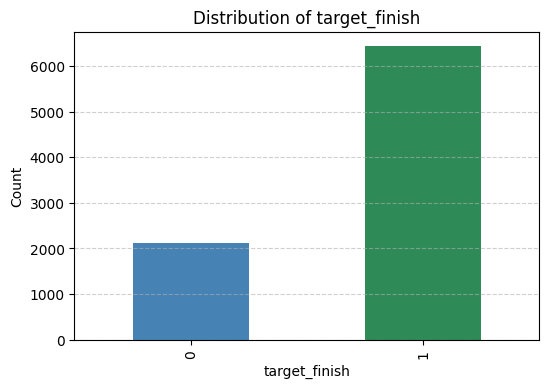

In [100]:
# Tell forekomster
counts = train_data['target_dnf'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['steelblue', 'seagreen'])

plt.title("Distribution of target_finish")
plt.xlabel("target_finish")
plt.ylabel("Count")
plt.xticks([0, 1], ["0", "1"])
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

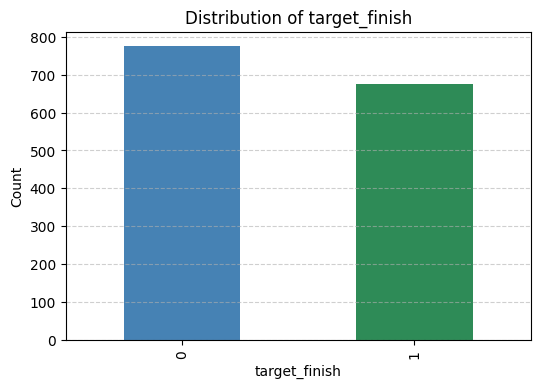

In [101]:
# Tell forekomster
counts = test_data['target_dnf'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['steelblue', 'seagreen'])

plt.title("Distribution of target_finish")
plt.xlabel("target_finish")
plt.ylabel("Count")
plt.xticks([0, 1], ["0", "1"])
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

As we can see above, the whole trainingset is not balanced. There are generally more dnf´s before 2015, than after 2015, making our predictions less reliable, as things has gotten safer. Our testset however, is balanced, which is a good thing.

## **Part_2_Models**

### **Logistical_regression**

Beginning of logistic regression
Starting with finding strong features using Lasso

In [102]:
random_seed = 2334

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

feature_extractor = LogisticRegression(penalty='l1', solver='liblinear', random_state=random_seed, C=1)

feature_extractor.fit(X_train_scaled, y_train)

#Threshold 0.05, this gives 19 features with C=1
thresh = 0.05

significant = X_train.columns[abs(feature_extractor.coef_[0])>thresh]
coefficients = feature_extractor.coef_[0][abs(feature_extractor.coef_[0])>thresh]
z = list(zip(significant, coefficients))
z.sort(key=lambda x: abs(x[1]), reverse=True)
significantSorted = [p[0] for p in z]

X_train_lasso = X_train[significant]
X_test_lasso = X_test[significant]

After Lasso has had its way with our features, we are left with 19
We will then test out different subsets of these in conjunction with changing the levels of regularization
To do this we will create a pipeline and use a Grid search

What happens in the following cell
1. We define a list of lists of features. These are selected based on the output of the previous cell, where lasso assigns higher coefficients to features with more predictive power. I try all, then only the significant ones, the 7 best, the best half, best quarter, worst half and then in the end constructors and circuits for fun (might remove these)
2. I define a parametergrid, currently the only parameter is C, which is the amount of lasso-regularization. 
3. I iterate through the different subsets of features, and do gridsearch, with a cv of 5, for each one of them. 
4. We save the best result of each feature-set

['grid', 'year', 'constructorRef_ferrari', 'constructorRef_mclaren', 'constructorRef_williams', 'circuitRef_nurburgring', 'constructorRef_red_bull', 'circuitRef_monaco', 'constructorRef_ligier', 'month_10', 'constructorRef_renault', 'constructorRef_team_lotus', 'circuitRef_spa', 'circuitRef_interlagos', 'alt', 'constructorRef_tyrrell', 'month_3', 'circuitRef_silverstone', 'circuitRef_villeneuve']
Baseline f1-score is: 0.8584779706275033
Baseline f1-score for test is: 0.6352941176470588
Model: Feature_Set_1_(35 columns)


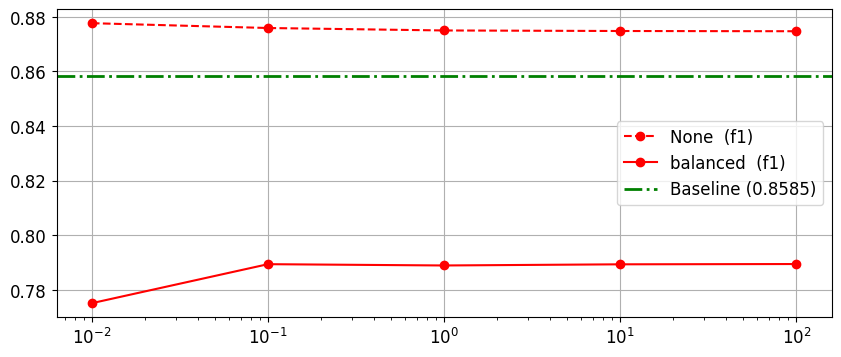

Test score for best model with current features is: 0.7013487475915221
Model: Feature_Set_2_(19 columns)


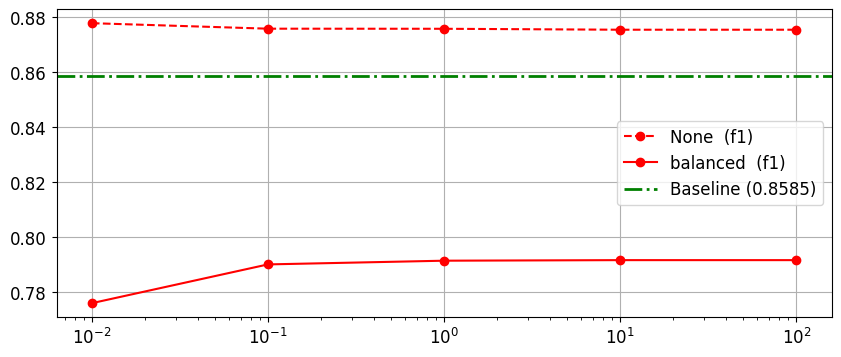

Test score for best model with current features is: 0.7013487475915221
Model: Feature_Set_3_(7 columns)


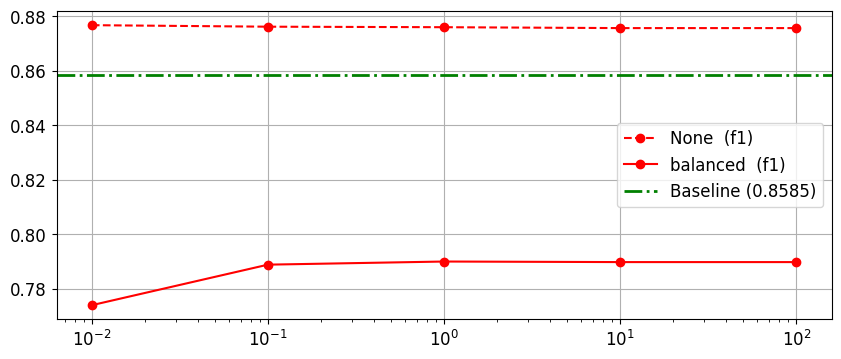

Test score for best model with current features is: 0.7014157014157014
Model: Feature_Set_4_(9 columns)


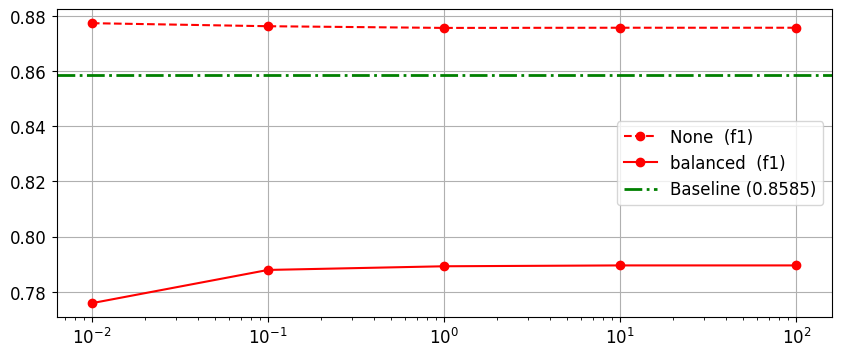

Test score for best model with current features is: 0.7035369774919614
Model: Feature_Set_5_(4 columns)


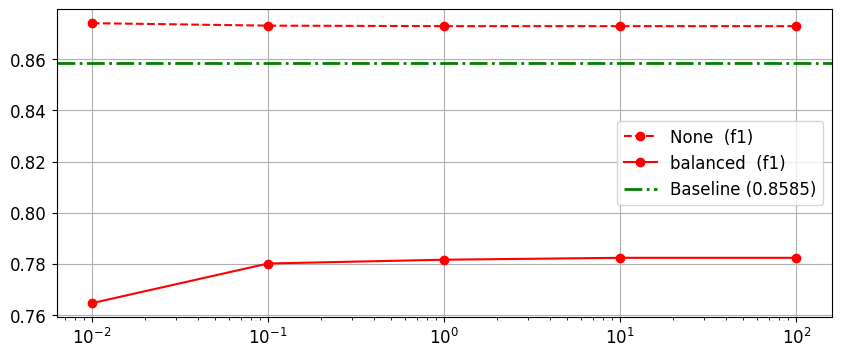

Test score for best model with current features is: 0.6990920881971465
Model: Feature_Set_6_(9 columns)


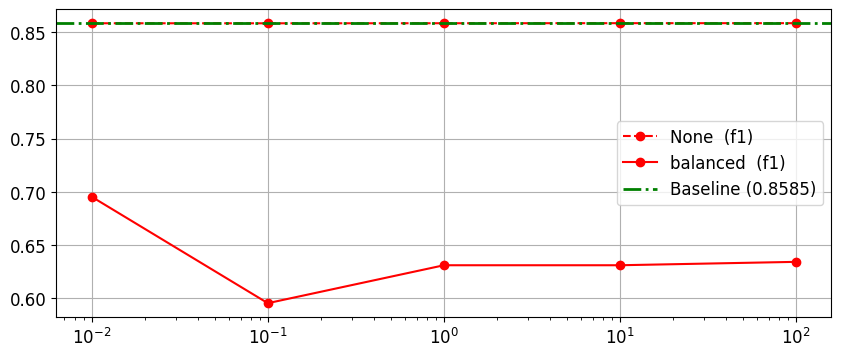

Test score for best model with current features is: 0.6320754716981132
**Feature_Set_1_(35 columns)**: Best Score = 0.8777, Best C = 0.0100
**Feature_Set_2_(19 columns)**: Best Score = 0.8778, Best C = 0.0100
**Feature_Set_3_(7 columns)**: Best Score = 0.8768, Best C = 0.0100
**Feature_Set_4_(9 columns)**: Best Score = 0.8775, Best C = 0.0100
**Feature_Set_5_(4 columns)**: Best Score = 0.8742, Best C = 0.0100
**Feature_Set_6_(9 columns)**: Best Score = 0.8586, Best C = 10.0000


In [103]:
print(significantSorted)

#We try all the features, the best half and quarter, as well as the worst half for fun
listsOfFeatures = [
    X_train.columns,
    significantSorted,
    significantSorted[0:7],
    significantSorted[0:len(significantSorted)//2],
    significantSorted[0:len(significantSorted)//4],
    significantSorted[len(significantSorted)//2:-1]
]

param_grid = {
    'model__C' : np.logspace(-2, 2, 5),
    'model__class_weight': [None, 'balanced'],
}


pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(solver='liblinear', penalty='l1', random_state=random_seed))
])


results = {}

#Finding baseline
baseLinePredictions = np.ones_like(y_train)
f1Baseline = f1_score(y_train, baseLinePredictions)
print(f"Baseline f1-score is: {f1Baseline}")

baseLinePredictionsTest = np.ones_like(y_test)
f1BaselineTest = f1_score(y_test, baseLinePredictionsTest)
print(f"Baseline f1-score for test is: {f1BaselineTest}")

for i, features in enumerate(listsOfFeatures):
    X_train_iter = X_train[features]
    X_test_iter = X_test[features]
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='f1')
    key = f"Feature_Set_{i+1}_({len(features)} columns)"
    grid.fit(X_train_iter, y_train)
    
    print(F"Model: {key}")

    logreg_result = unpack_gridsearch(grid)
    plot_grid_result(logreg_result, baseline=f1Baseline)

    y_hat = grid.predict(X_test_iter)

    test_score = f1_score(y_test, y_hat)
    

    print(f"Test score for best model with current features is: {test_score}")


    #Storing results
    results[key] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'features_used': features
    }
    

for key, res in results.items():
    print(f"**{key}**: Best Score = {res['best_score']:.4f}, Best C = {res['best_params']['model__C']:.4f}")


### **Random Forest**

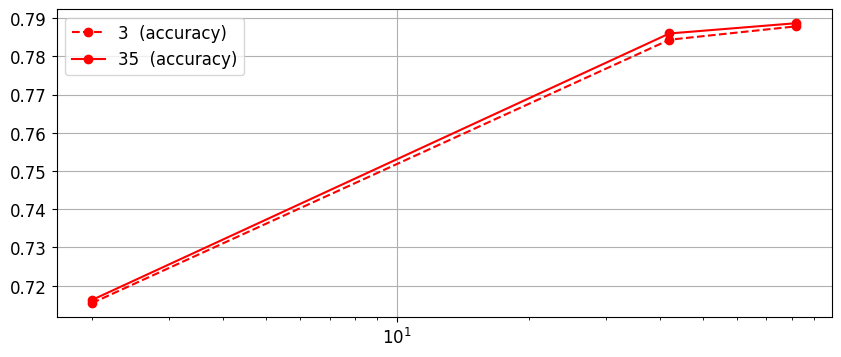

In [104]:
from sklearn.ensemble import RandomForestClassifier
from utils import hypersolve

rng_seed = 42

param_grid_rf = {
    'model__max_features' : [3, X_train.shape[1]],
    'model__n_estimators' : [2,42,82]
}

model = RandomForestClassifier(random_state=rng_seed)

result_rf = hypersolve(model, param_grid_rf, X_train, y_train)

# **SVM**

## Imports

In [ ]:
import numpy as np
import pandas as pd

# Model selection & evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Models
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.base import clone

# Preprocessing & pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Configuration and Data Loading

In this section, we:

- Define a few global **configuration variables** (e.g., `RANDOM_STATE`, `TEST_SIZE`) to keep experiments consistent across models.
- **Load** the pre-cleaned F1 dataset from disk.
- Do a quick **sanity check** of the data shape and the target distribution for `target_finish` (DNF vs finished).

In [ ]:
# Configuration
RANDOM_STATE = 42
DATA_PATH = "processed_data.csv"

# Helper function to print evaluation metrics
def evaluate_model(name, y_true, y_pred):
    print(f"=== {name} ===")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1       : {f1_score(y_true, y_pred):.4f}")

# Load dataset
df = pd.read_csv(DATA_PATH)

# Quick sanity checks
print("Dataset shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

print("\nTarget distribution (counts):")
print(df["target_finish"].value_counts())

print("\nTarget distribution (proportions):")
print(df["target_finish"].value_counts(normalize=True))

Dataset shape: (10000, 37)

Columns:
 ['year', 'round', 'grid', 'alt', 'target_finish', 'constructorRef_brabham', 'constructorRef_ferrari', 'constructorRef_ligier', 'constructorRef_mclaren', 'constructorRef_red_bull', 'constructorRef_renault', 'constructorRef_sauber', 'constructorRef_team_lotus', 'constructorRef_tyrrell', 'constructorRef_williams', 'circuitRef_hockenheimring', 'circuitRef_hungaroring', 'circuitRef_interlagos', 'circuitRef_monaco', 'circuitRef_monza', 'circuitRef_nurburgring', 'circuitRef_red_bull_ring', 'circuitRef_silverstone', 'circuitRef_spa', 'circuitRef_villeneuve', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'target_dnf']

Target distribution (counts):
target_finish
0    7105
1    2895
Name: count, dtype: int64

Target distribution (proportions):
target_finish
0    0.7105
1    0.2895
Name: proportion, dtype: float64


## Train/Test Split (Time-based, aligned with main pipeline)

We follow the global preprocessing pipeline and split the data by year:

- **Train set**: races up to and including 2015  
- **Test set**: races after 2015  

The feature matrix `X` excludes both `target_finish` and `target_dnf`, and the
label vector `y` uses `target_dnf` (1 = DNF, 0 = finish).

In [ ]:
## Train/Test Split (Time-based, aligned with main pipeline)

cutoff_year = 2015

# Use the loaded processed dataframe (df) instead of encoded_data
train_data = df[df["year"] <= cutoff_year].copy()
test_data  = df[df["year"] >  cutoff_year].copy()

# Feature matrix X excludes both target columns
X_train = train_data.drop(columns=["target_finish", "target_dnf"])
y_train = train_data["target_dnf"]

X_test  = test_data.drop(columns=["target_finish", "target_dnf"])
y_test  = test_data["target_dnf"]

print("Training size (X, y):", X_train.shape, ",", len(y_train))
print("Test size (X, y):", X_test.shape, ",", len(y_test))

print("\nChecking that targets are not in X columns:")
for col in ["target_finish", "target_dnf"]:
    print(f"{col} in X_train? {col in X_train.columns}")

Training size (X, y): (8550, 35) , 8550
Test size (X, y): (1450, 35) , 1450

Checking that targets are not in X columns:
target_finish in X_train? False
target_dnf in X_train? False


## SVM Baseline Model

We start with a simple Support Vector Machine classifier using:
- `StandardScaler` for feature normalization
- default `SVC` settings


We evaluate performance using Accuracy, Precision, Recall, and F1 (with DNF = 1 as the positive class).

In [ ]:
# Baseline SVM pipeline: StandardScaler + default SVC
svm_baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(random_state=RANDOM_STATE))
])

# Fit model
svm_baseline.fit(X_train, y_train)

# Predict test set
y_pred_baseline = svm_baseline.predict(X_test)

# Evaluate
evaluate_model("Baseline SVM (DNF = 1)", y_test, y_pred_baseline)

=== Baseline SVM (DNF = 1) ===
Accuracy : 0.6303
Precision: 0.5785
Recall   : 0.7585
F1       : 0.6564


## SVM Hyperparameter Search (Grid Search)

In this section, we perform a hyperparameter search for the SVM model using `GridSearchCV`.

We vary:
- `kernel` (linear, rbf, poly)
- `C` (regularization strength)
- `gamma` (kernel coefficient for rbf and poly)
- optionally `class_weight` (to account for class imbalance)

We use 5-fold cross-validation on the training data and optimize for **F1 score** with DNF = 1 as the positive class.

In [ ]:
# Define SVM pipeline
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(random_state=RANDOM_STATE))
])

# Hyperparameter grid
param_grid = {
    "model__kernel": ["linear", "rbf", "poly"],
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", 0.1, 0.01],  # gamma used for rbf/poly
}

# Grid search object
svm_grid = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=0,
)

# Fit on training data
svm_grid.fit(X_train, y_train)

print("Best params from grid search:")
print(svm_grid.best_params_)
print(f"Best CV F1: {svm_grid.best_score_:.4f}")

Best params from grid search:
{'model__C': 10, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
Best CV F1: 0.8711


## Top-K SVM Models: Test Set Performance

Instead of only looking at the single best SVM model, we also inspect the
top **K** hyperparameter configurations from the grid search.

For each of the top-K models (ranked by mean CV F1 score), we:
- refit the model on the full training set
- evaluate it on the test set
- report Accuracy, Precision, Recall, and F1 (DNF = 1 as the positive class)

In [ ]:
TOP_K = 10  # number of top SVM models you want to inspect

# Extract and sort by mean_test_score (which corresponds to CV F1 because scoring="f1")
cv_results = pd.DataFrame(svm_grid.cv_results_)
cv_results_sorted = cv_results.sort_values(
    by="mean_test_score", ascending=False
).reset_index(drop=True)

top_k_rows = cv_results_sorted.head(TOP_K)

records = []

# ==== 1) Add Dummy Baseline as Rank 0 ====

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_dummy = dummy_clf.predict(X_test)

records.append({
    "rank": 0,
    "params": "Dummy(most_frequent)",
    "cv_mean_f1": None,
    "cv_std_f1": None,
    "test_accuracy": accuracy_score(y_test, y_dummy),
    "test_precision": precision_score(y_test, y_dummy, zero_division=0),
    "test_recall": recall_score(y_test, y_dummy, zero_division=0),
    "test_f1": f1_score(y_test, y_dummy, zero_division=0),
})

# ==== 2) Add Top-K SVM Models ====

for idx, row in top_k_rows.iterrows():
    params = row["params"]

    # Clone base pipeline and set hyperparameters
    model = clone(svm_grid.estimator)
    model.set_params(**params)

    # Fit on full training data
    model.fit(X_train, y_train)

    # Evaluate on test data
    y_pred = model.predict(X_test)

    rec = {
        "rank": idx + 1,
        "params": params,
        "cv_mean_f1": row["mean_test_score"],
        "cv_std_f1": row["std_test_score"],
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_precision": precision_score(y_test, y_pred, zero_division=0),
        "test_recall": recall_score(y_test, y_pred, zero_division=0),
        "test_f1": f1_score(y_test, y_pred, zero_division=0),
    }
    records.append(rec)

# Convert to DataFrame
comparison_df = pd.DataFrame(records)

pd.set_option("display.max_colwidth", None)
display(comparison_df)

,rank,params,cv_mean_f1,cv_std_f1,test_accuracy,test_precision,test_recall,test_f1
0,0,Dummy(most_frequent),NaN,NaN,0.465517,0.465517,1.000000,0.635294
1,1,"{'model__C': 10, 'model__gamma': 0.01, 'model__kernel': 'rbf'}",0.871087,0.005852,0.631724,0.585248,0.717037,0.644474
2,2,"{'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}",0.870956,0.004408,0.639310,0.610145,0.623704,0.616850
3,3,"{'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'poly'}",0.868662,0.005802,0.605517,0.555917,0.758519,0.641604
4,4,"{'model__C': 10, 'model__gamma': 0.01, 'model__kernel': 'poly'}",0.868447,0.003263,0.608276,0.557465,0.768889,0.646326
5,5,"{'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}",0.868260,0.005652,0.630345,0.578531,0.758519,0.656410
6,6,"{'model__C': 1, 'model__gamma': 0.01, 'model__kernel': 'rbf'}",0.868021,0.004663,0.628966,0.575691,0.771852,0.659494
7,7,"{'model__C': 0.1, 'model__gamma': 0.1, 'model__kernel': 'poly'}",0.867790,0.003505,0.634483,0.588523,0.714074,0.645248
8,8,"{'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'poly'}",0.867469,0.003387,0.633103,0.595716,0.659259,0.625879
9,9,"{'model__C': 1, 'model__gamma': 0.01, 'model__kernel': 'linear'}",0.866362,0.003448,0.606897,0.565543,0.671111,0.613821


## SVM Feature Subset Experiments
Using the best SVM hyperparameters found by the grid search (`kernel`, `C`, and `gamma`),  
we investigate how performance changes when we restrict the model to fewer input features.

We compute the absolute Pearson correlation between each **numeric** feature and the target
   label `target_dnf`.
We define four feature sets:
   - **all_features** – all columns used in the original SVM
   - **top_15_corr** – the 15 most correlated features with `target_dnf`
   - **top_10_corr** – the 10 most correlated features
   - **top_5_corr**  – the 5 most correlated features

For each feature set we:
   - train the same “best” SVM (same kernel, `C`, and `gamma`),
   - evaluate Accuracy, Precision, Recall, and F1 on the test set.


In [ ]:
# Use the best hyperparameters from the grid search
best_params = svm_grid.best_params_
print("Best SVM params:", best_params)

# Compute correlations with the target for numeric features
corr = df.corr(numeric_only=True)["target_dnf"].abs().sort_values(ascending=False)

# Drop the target itself
corr = corr.drop(labels=["target_dnf", "target_finish"], errors="ignore")

print("\nTop 15 features by |correlation with target_dnf|:")
print(corr.head(15))

# Define different feature subsets
feature_sets = {
    "all_features": X_train.columns.tolist(),
    "top_15_corr": corr.head(15).index.tolist(),
    "top_10_corr": corr.head(10).index.tolist(),
    "top_5_corr":  corr.head(5).index.tolist(),
}

# Train the same best SVM on each subset and evaluate
feature_records = []

for name, cols in feature_sets.items():
    print(f"\n=== Training best SVM on {name} ({len(cols)} features) ===")
    
    X_train_sub = X_train[cols]
    X_test_sub  = X_test[cols]
    
    svm_best = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(random_state=RANDOM_STATE)),
    ])
    svm_best.set_params(**best_params)
    
    svm_best.fit(X_train_sub, y_train)
    y_pred_sub = svm_best.predict(X_test_sub)
    
    feature_records.append({
        "features": name,
        "n_features": len(cols),
        "test_accuracy":  accuracy_score(y_test, y_pred_sub),
        "test_precision": precision_score(y_test, y_pred_sub, zero_division=0),
        "test_recall":    recall_score(y_test, y_pred_sub, zero_division=0),
        "test_f1":        f1_score(y_test, y_pred_sub, zero_division=0),
    })

feature_results_df = pd.DataFrame(feature_records)
display(feature_results_df)

Best SVM params: {'model__C': 10, 'model__gamma': 0.01, 'model__kernel': 'rbf'}

Top 15 features by |correlation with target_dnf|:
grid                       0.344964
year                       0.276936
constructorRef_ferrari     0.183788
constructorRef_red_bull    0.179034
constructorRef_mclaren     0.145330
round                      0.123115
constructorRef_williams    0.107466
constructorRef_ligier      0.076682
month_11                   0.059469
constructorRef_tyrrell     0.050984
constructorRef_brabham     0.049485
month_5                    0.047390
circuitRef_monaco          0.044537
circuitRef_spa             0.043378
alt                        0.043222
Name: target_dnf, dtype: float64

=== Training best SVM on all_features (35 features) ===

=== Training best SVM on top_15_corr (15 features) ===

=== Training best SVM on top_10_corr (10 features) ===

=== Training best SVM on top_5_corr (5 features) ===


,features,n_features,test_accuracy,test_precision,test_recall,test_f1
0,all_features,35,0.631724,0.585248,0.717037,0.644474
1,top_15_corr,15,0.626207,0.566969,0.834074,0.675060
2,top_10_corr,10,0.626207,0.567104,0.832593,0.674670
3,top_5_corr,5,0.624138,0.563725,0.851852,0.678466


## Uncertainty via Distance to the Decision Boundary
We take the best SVM pipeline from the grid search and compute
  `decision_function(X_test)`, which returns a signed score proportional to the distance
  of each test example from the decision boundary.
- We look at the **absolute value** of these scores (the margin) and summarize them by:
  - median |margin|,
  - 10th percentile |margin| (examples close to the boundary, more uncertain),
  - 90th percentile |margin| (examples far from the boundary, more confident).

In [ ]:
# Best full pipeline from grid search (includes scaler + SVC)
best_svm = svm_grid.best_estimator_

# decision_function gives signed distance-like scores to the decision boundary
decision_scores = best_svm.decision_function(X_test)
abs_scores = np.abs(decision_scores)

print("Number of test examples:", len(abs_scores))
print(f"Median |margin|          : {np.median(abs_scores):.4f}")
print(f"10th percentile |margin| : {np.percentile(abs_scores, 10):.4f}")
print(f"90th percentile |margin| : {np.percentile(abs_scores, 90):.4f}")

Number of test examples: 1450
Median |margin|          : 0.7052
10th percentile |margin| : 0.1773
90th percentile |margin| : 1.6067


### **Neural Network**

#### **Intro**

In this part of the project, we focus on Neural Networks. Broadly, neural network architectures can be divided into four major families: MLPs, RNNs, CNNs, and Transformers. Each of these architectures is designed to handle different data structures. Since our dataset does not contain sequential or spatial structure, there is no temporal dependency or context from one row to the next.

Because of this, architectures that rely on such structure—RNNs (designed for sequence modeling), CNNs (designed for spatial patterns), and Transformers (designed for long-range contextual dependencies)—are not suitable here. Instead, MLPs (Multi-Layer Perceptrons) are the most appropriate choice, as they perform best on tabular, independent samples where each row is treated as a standalone input.

In [105]:
# ========================================================
# PARAMETER GRID 32 models
# ========================================================

param_grid = {
    "depth": [
        [256, 128],
        [512, 256],
        [512, 256, 128],
        [256, 128, 64]
    ],

    "dropout": [0.0, 0.05],

    "activation": [
        tf.keras.activations.relu,
        tf.keras.activations.gelu
    ],

    "l2_reg": [0.0]
}


# ========================================================
# BUILD MODEL
# ========================================================

input_dim = X_train_lasso.shape[1]

def build_mlp(hidden_layers, activation, dropout, l2_reg):

    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for h in hidden_layers:
        model.add(layers.Dense(
            h,
            activation=None,
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        model.add(layers.Dropout(dropout))

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


# ========================================================
# GRID SEARCH
# ========================================================

results = []
best_model = None
best_test_acc = -1
best_history = None
model_id = 1

EPOCHS = 20
BATCH = 32

for depth in param_grid["depth"]:
    for dropout in param_grid["dropout"]:
        for activation in param_grid["activation"]:
            for l2_reg in param_grid["l2_reg"]:

                print(f"\n=== MODEL {model_id} ===")
                print(f"Depth:      {depth}")
                print(f"Dropout:    {dropout}")
                print(f"Activation: {activation}")
                print(f"L2:         {l2_reg}")

                model = build_mlp(depth, activation, dropout, l2_reg)

                history = model.fit(
                    X_train_lasso, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH,
                    verbose=0
                )

                test_loss, test_acc = model.evaluate(
                    X_test_lasso, y_test,
                    verbose=0
                )

                print(f" → Test accuracy: {test_acc:.4f}")

                results.append({
                    "model_id": model_id,
                    "depth": depth,
                    "dropout": dropout,
                    "activation": activation.__name__,
                    "l2_reg": l2_reg,
                    "test_acc": test_acc,
                    "history": history.history
                })

                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    best_model = model
                    best_history = history.history

                model_id += 1

print("\n===================================")
print(" BEST TEST ACCURACY:", best_test_acc)
print("===================================")



=== MODEL 1 ===
Depth:      [256, 128]
Dropout:    0.0
Activation: <function relu at 0x162a6e480>
L2:         0.0
 → Test accuracy: 0.5800

=== MODEL 2 ===
Depth:      [256, 128]
Dropout:    0.0
Activation: <function gelu at 0x16313ede0>
L2:         0.0
 → Test accuracy: 0.5234

=== MODEL 3 ===
Depth:      [256, 128]
Dropout:    0.05
Activation: <function relu at 0x162a6e480>
L2:         0.0
 → Test accuracy: 0.6228

=== MODEL 4 ===
Depth:      [256, 128]
Dropout:    0.05
Activation: <function gelu at 0x16313ede0>
L2:         0.0
 → Test accuracy: 0.6428

=== MODEL 5 ===
Depth:      [512, 256]
Dropout:    0.0
Activation: <function relu at 0x162a6e480>
L2:         0.0
 → Test accuracy: 0.4959

=== MODEL 6 ===
Depth:      [512, 256]
Dropout:    0.0
Activation: <function gelu at 0x16313ede0>
L2:         0.0
 → Test accuracy: 0.5903

=== MODEL 7 ===
Depth:      [512, 256]
Dropout:    0.05
Activation: <function relu at 0x162a6e480>
L2:         0.0
 → Test accuracy: 0.5869

=== MODEL 8 ===


In [106]:

# SORT AND PRINT RESULTS

results_sorted = sorted(results, key=lambda x: x["test_acc"], reverse=True)

print("\n===============================")
print(" TOP MODELS")
print("===============================\n")

for r in results_sorted[:4]:
    print(f"Model {r['model_id']} — acc={r['test_acc']:.4f}")
    print(f"  depth={r['depth']}")
    print(f"  dropout={r['dropout']}")
    print(f"  activation={r['activation']}")
    print(f"  L2={r['l2_reg']}")
    print("---------------------------------")



 TOP MODELS

Model 9 — acc=0.6676
  depth=[512, 256, 128]
  dropout=0.0
  activation=relu
  L2=0.0
---------------------------------
Model 4 — acc=0.6428
  depth=[256, 128]
  dropout=0.05
  activation=gelu
  L2=0.0
---------------------------------
Model 11 — acc=0.6407
  depth=[512, 256, 128]
  dropout=0.05
  activation=relu
  L2=0.0
---------------------------------
Model 14 — acc=0.6255
  depth=[256, 128, 64]
  dropout=0.0
  activation=gelu
  L2=0.0
---------------------------------


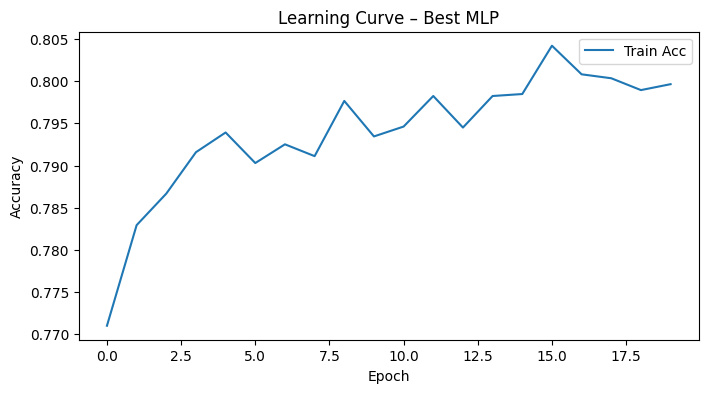

In [107]:
best = results_sorted[0]["history"]

plt.figure(figsize=(8,4))
plt.plot(best["accuracy"], label="Train Acc")
plt.title("Learning Curve – Best MLP")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


The learning rate appears to be relatively high, which results in noticeable fluctuations in the accuracy curve. However, we are required to use the default optimizer settings in this project, and therefore cannot adjust the learning rate.

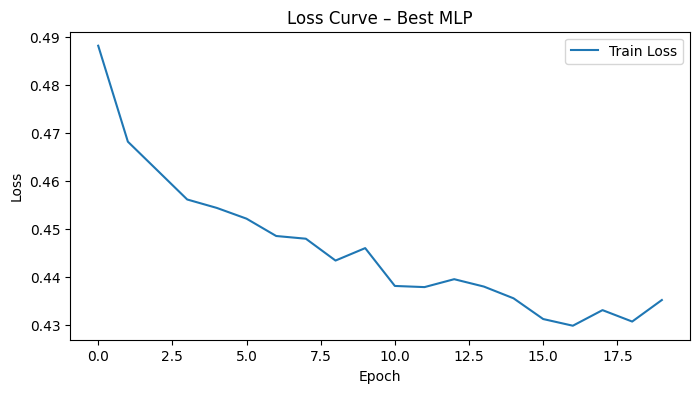

In [108]:
best = results_sorted[0]["history"]

plt.figure(figsize=(8,4))
plt.plot(best["loss"], label="Train Loss")
plt.title("Loss Curve – Best MLP")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The loss curves show a consistent downward trend for both the training and validation sets, indicating that the model continues to learn throughout the training process. Although the validation loss fluctuates slightly from epoch to epoch, this is expected given the relatively small validation set and the fixed optimizer settings required by the project. Overall, the training and validation loss follow similar trajectories, suggesting that the model generalizes reasonably well without severe overfitting.